## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#import tensorflow
#print(tensorflow.__file__)
#!pip show tensorflow
#import sys
#sys.path += ['C:\\Users\\cleme\\AppData\\Roaming\\Python\\Python36\\Scripts']
#sys.path += ['c:\\users\\cleme\\anaconda3\\Scripts']
#sys.path = ['C:\\Users\\cleme\\Anaconda3\\lib\\site-packages'] + sys.path
#sys.path

In [3]:
import tensorflow
print(tensorflow.__file__)
print(tensorflow.__version__)

C:\Users\cleme\Anaconda3\lib\site-packages\tensorflow\__init__.py
2.1.0


In [4]:
# uninstall scikit-learn and install this version
#! pip install --user scikit-learn==0.21.2
#! pip install --user sktime
#! pip install --user tensorflow_addons
#! pip install --user tensorflow
#! pip install --user fastcache
#! pip install --user lxml
#! pip install --user nltk
#! pip install --user --upgrade grpcio

## Import data

In [20]:
file_path = "C:/Users/cleme/Desktop/ENSAE_3a/Deep Learning for Medical Imaging/ECG5000/"

f = open(file_path + "ECG5000_TRAIN.txt")
ECG5000_test = f.readlines()
f.close()

f = open(file_path + "ECG5000_TEST.txt")
ECG5000_train = f.readlines()
f.close()

## Prepare data for 1D-Convolutional layers

In [21]:
def to_float(list_str):
    if list_str == []:
        return []
    return [float(list_str[0])] + to_float(list_str[1:])

In [36]:
# Run this for classical NN

data_train = []
labels_train = []

for d in ECG5000_train:
    temp = d.split()
    labels_train += [int(temp[0][:1])]
    data_train += [to_float(temp[1:])]
    
data_train = np.array(data_train)
labels_train = np.array(labels_train)
    
#data_train = np.array(data_train)
#labels_train = np.array(labels_train)

data_test = []
labels_test = []

for d in ECG5000_test:
    temp = d.split()
    labels_test += [int(temp[0][:1])]
    data_test += [to_float(temp[1:])]
    
data_test = np.array(data_test)
labels_test = np.array(labels_test)

In [37]:
#print(data_train.shape) # 500 time series of size 140
#print(labels_train.shape)

print(data_test.shape) # 500 time series of size 140
print(labels_test.shape)

(500, 140)
(500,)


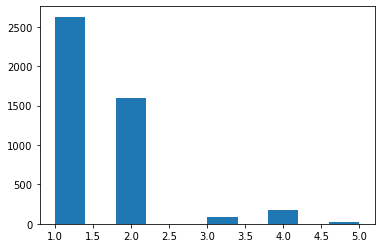

In [38]:
hist_train = plt.hist(labels_train) # The dataset is clearly unbalanced

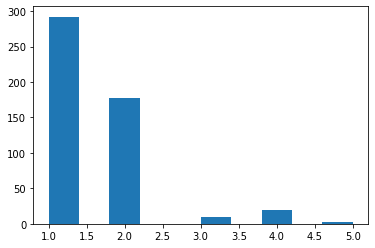

In [39]:
hist_test = plt.hist(labels_test) # The dataset is clearly unbalanced

In [40]:
hist_test

(array([292.,   0., 177.,   0.,   0.,  10.,   0.,  19.,   0.,   2.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

In [41]:
print(np.sum(hist_train[0][:3])/np.sum(hist_train[0]))
print(np.sum(hist_test[0][:3])/np.sum(hist_test[0]))

0.9371111111111111
0.938


## Increasing low represented classes 

In [28]:
# We increase data_test because we use it as training data and data_training as test data
# PS : try with and without this to see if it is better

indices = {}

for i,lab in enumerate(labels_train):
    indices[lab] = indices.get(lab,[]) + [i]
    
data_train_ = []
labels_train_ = []

for k in range(3,6):
    for ind in indices[k]:
        data_train_ += [data_train[ind]]
        data_train_ += [data_train[ind]]
        labels_train_ += [k]
        labels_train_ += [k]

for k in range(1,3):
    for _ in range(100):
        ind = np.random.randint(len(indices[k]))
        ind = indices[k][ind]
        data_train_ += [data_train[ind]]
        labels_train_ += [k]
        
data_train = np.array(data_train_)
labels_train = np.array(labels_train_)

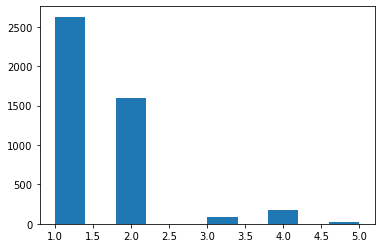

In [42]:
hist_train = plt.hist(labels_train) # The dataset is a little bit unbalanced

In [43]:
data_train_1D = np.reshape(data_train,(data_train.shape[0],data_train.shape[1],1))
data_test_1D = np.reshape(data_test,(data_test.shape[0],data_test.shape[1],1))

n_classes = 5

# Adapt labels for multi-class classification
labels_train_ = np.zeros((len(labels_train),n_classes))
for i,lab in enumerate(labels_train):
  labels_train_[i,lab-1] = 1

labels_test_ = np.zeros((len(labels_test),n_classes))
for i,lab in enumerate(labels_test):
  labels_test_[i,lab-1] = 1

## Testing models

In [44]:
import tensorflow_addons as tfa
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Reshape, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense, BatchNormalization,BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
def mish(x):
    return x * tensorflow.math.tanh(tensorflow.math.softplus(x))


def add_conv_block_input(model, n_filters, kern_size, n_stride, fc_act, pooling, coeff_dropout, input_shape):
    model.add(Conv1D(filters = n_filters, kernel_size = kern_size, 
                     strides = n_stride, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation(fc_act))
    model.add(Dropout(coeff_dropout))
    model.add(Conv1D(filters = n_filters, kernel_size = kern_size, 
                     strides = n_stride, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(fc_act))
    model.add(Dropout(coeff_dropout))
    model.add(pooling)
    
def add_conv_block(model, n_filters, kern_size, n_stride, fc_act, coeff_dropout, pooling):
    model.add(Conv1D(filters = n_filters, kernel_size = kern_size, 
                     strides = n_stride, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(fc_act))
    model.add(Dropout(coeff_dropout))
    model.add(Conv1D(n_filters, n_stride, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation(fc_act))
    model.add(Dropout(coeff_dropout))
    model.add(pooling)
    
def slid_wind_acc(acc,window):
    res = []
    for k in range(len(acc)-window):
        res += [np.mean(acc[k:k+window])]
    plt.plot(res)
    plt.show(block=True)

In [45]:
# 1D-CNN takes in input (n_data,len_sequences,n_sensors)
# here we have only one sensor but we still need data to be in shape (n_data,len_sequences,1)
# and not (n_data,len_sequences)

def model_(n_filters,kern_size,n_stride,fc_act,n_classes,add_FC,input_shape):

    model = Sequential()

    add_conv_block_input(model, n_filters, kern_size, n_stride, fc_act, MaxPooling1D(3), 0.1, input_shape)
    add_conv_block(model, 2*n_filters, kern_size, n_stride, fc_act, 0.1, MaxPooling1D(3))
    #add_conv_block(model, 4, n_init, n_stride, fc_act, GlobalAveragePooling1D())
    add_conv_block(model, 4*n_filters, kern_size, n_stride, fc_act,0.1, MaxPooling1D(3))

    model.add(Flatten())
    if add_FC:
        model.add(Dense(30))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    
    model.add(Dense(n_classes, activation='softmax'))

    print(model.summary())
    return model

# 1D-CNN takes in input (n_data,len_sequences,n_sensors)
# here we have only one sensor but we still need data to be in shape (n_data,len_sequences,1)
# and not (n_data,len_sequences)

class ResNet(tensorflow.keras.Model):
  def __init__(self):
    super(ResNet, self).__init__(name='')
    

    self.conv_input = Conv1D(filters = 4, kernel_size = 32, 
                                   strides = 1, padding='same', activation='linear',
                                   input_shape=(140,1))
    
    #Residual Block 1
    self.conv1aa = Conv1D(filters = 4, kernel_size = 4, 
                                   strides = 1, padding='same', activation='linear')
    self.conv1ab = Conv1D(filters = 4, kernel_size = 32, 
                                   strides = 1, padding='same', activation='linear')
    self.conv1b = Conv1D(filters = 4, kernel_size = 32, 
                                   strides = 1, padding='same', activation='linear')
    self.max_pool1 = MaxPooling1D(pool_size=3, strides=None)
    
    #Residual Block 2
    self.conv2aa = Conv1D(filters = 8, kernel_size = 4, 
                                   strides = 1, padding='same', activation='linear')
    self.conv2ab = Conv1D(filters = 8, kernel_size = 32, 
                                   strides = 1, padding='same', activation='linear')
    self.conv2b = Conv1D(filters = 8, kernel_size = 32, 
                                   strides = 1, padding='same', activation='linear')
    self.max_pool2 = MaxPooling1D(pool_size=3, strides=None)
    
    
    #End Block
    self.Flatten_ = Flatten()
    self.Dense1 = Dense(units=32, activation='relu')
    self.Dense2 = Dense(units=5, activation='softmax')

  def call(self, input_tensor):
    x_inp = self.conv_input(input_tensor)
    
    x1aa = self.conv1aa(x_inp)
    x1aa = BatchNormalization()(x1aa)
    x1aa = Activation('relu')(x1aa)
    x1aa = Dropout(0.1)(x1aa)
    
    x1ab = self.conv1ab(x_inp)
    x1ab = BatchNormalization()(x1ab)
    x1ab = Activation('relu')(x1ab)
    x1ab = Dropout(0.1)(x1ab)
    
    x1a  = x1aa + x1ab
    x1 = self.conv1b(x1a)
    x2 = self.max_pool1(x1)
    
    x2aa = self.conv2aa(x2)
    x2aa = BatchNormalization()(x2aa)
    x2aa = Activation('relu')(x2aa)
    x2aa = Dropout(0.1)(x2aa)
    
    x2ab = self.conv2ab(x2)
    x2ab = BatchNormalization()(x2ab)
    x2ab = Activation('relu')(x2ab)
    x2ab = Dropout(0.1)(x2ab)
    
    x2a  = x2aa + x2ab
    x2 = self.conv2b(x2a)
    x3 = self.max_pool2(x2)
    
    x = self.Flatten_(x3)
    x = self.Dense1(x)
    return self.Dense2(x)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 140, 2)            66        
_________________________________________________________________
batch_normalization_12 (Batc (None, 140, 2)            8         
_________________________________________________________________
activation_12 (Activation)   (None, 140, 2)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 140, 2)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 140, 2)            130       
_________________________________________________________________
batch_normalization_13 (Batc (None, 140, 2)            8         
_________________________________________________________________
activation_13 (Activation)   (None, 140, 2)           

4500/4500 [==============================] - 4s 922us/sample - loss: 0.1570 - accuracy: 0.9540 - val_loss: 0.1355 - val_accuracy: 0.9580
Epoch 28/50
4500/4500 [==============================] - 4s 895us/sample - loss: 0.1528 - accuracy: 0.9533 - val_loss: 0.1314 - val_accuracy: 0.9600
Epoch 29/50
4500/4500 [==============================] - 4s 951us/sample - loss: 0.1530 - accuracy: 0.9527 - val_loss: 0.1386 - val_accuracy: 0.9620
Epoch 30/50
4500/4500 [==============================] - 4s 882us/sample - loss: 0.1580 - accuracy: 0.9527 - val_loss: 0.1313 - val_accuracy: 0.9620
Epoch 31/50
4500/4500 [==============================] - 4s 877us/sample - loss: 0.1559 - accuracy: 0.9529 - val_loss: 0.1282 - val_accuracy: 0.9620
Epoch 32/50
4500/4500 [==============================] - 4s 908us/sample - loss: 0.1539 - accuracy: 0.9518 - val_loss: 0.1421 - val_accuracy: 0.9620
Epoch 33/50
4500/4500 [==============================] - 4s 886us/sample - loss: 0.1523 - accuracy: 0.9518 - val_loss:

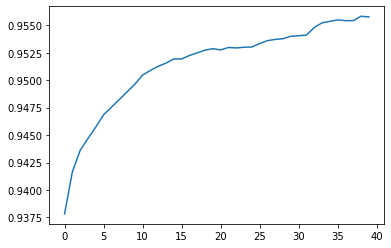

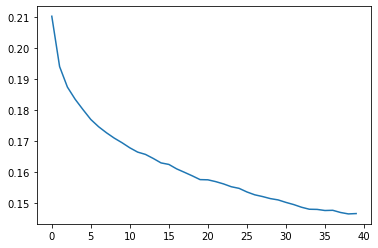

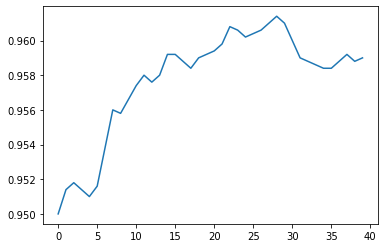

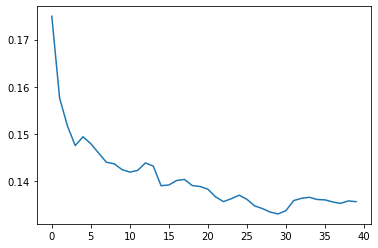

[[291   1   0   0   0]
 [  0 176   0   1   0]
 [  0   4   5   1   0]
 [  0  13   0   6   0]
 [  0   0   1   0   1]]
max val_accuracy is :  0.966
###############################
Wall time: 3min 44s


In [46]:
%%time

#model = ResNet()
model = model_(2,32,1,'relu',5,False,(140,1))

loss_classif = tensorflow.keras.losses.categorical_crossentropy

optimizer = SGD(learning_rate=0.05)
optimizer = tfa.optimizers.SWA(optimizer, start_averaging=0, average_period=3)

metrics_classif  =  ['accuracy']

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)


bs = 32
n_epochs = 50

history = model.fit(data_train_1D, labels_train_, batch_size=bs, epochs=n_epochs, 
                    validation_data=(data_test_1D, labels_test_),verbose=True)
    
slid_wind_acc(history.history['accuracy'],10)
slid_wind_acc(history.history['loss'],10)
slid_wind_acc(history.history['val_accuracy'],10)
slid_wind_acc(history.history['val_loss'],10)

print(confusion_matrix(labels_test, 1+np.apply_along_axis(np.argmax,1,model.predict(data_test_1D))))

print('max val_accuracy is : ',np.max(history.history['val_accuracy']))
print('###############################')

In [35]:
model_balanced = model

In [66]:
pred = 1+np.apply_along_axis(np.argmax,1,model.predict(data_test_1D))
pred_balanced = 1+np.apply_along_axis(np.argmax,1,model_balanced.predict(data_test_1D))
                                      
pred_ = []
for k in range(500):
    if pred[k]==1 or pred[k]==2:
        pred_ += [pred[k]]
    elif pred_balanced[k]==3 or pred_balanced[k]==4 or pred_balanced[k]==5:
        pred_ += [pred_balanced[k]]
    else:
        pred_ += [pred[k]]

mat = confusion_matrix(labels_test,pred_)
print(mat)
print(np.sum(np.diag(mat))/np.sum(mat))

[[291   1   0   0   0]
 [  0 176   0   1   0]
 [  0   4   5   1   0]
 [  0  13   0   6   0]
 [  0   0   0   1   1]]
0.958


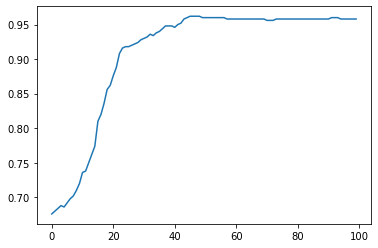

In [73]:
pred = model.predict(data_test_1D)
pred_b = model_balanced.predict(data_test_1D)
accuracy = []
for alpha in np.linspace(0,1,100):
    pred_ = 1+np.apply_along_axis(np.argmax,1,alpha*pred+(1-alpha)*pred_b)
    mat = confusion_matrix(labels_test,pred_)
    accuracy += [np.sum(np.diag(mat))/np.sum(mat)]

plt.plot(accuracy)

In [74]:
accuracy

[0.676,
 0.68,
 0.684,
 0.688,
 0.686,
 0.692,
 0.698,
 0.702,
 0.71,
 0.72,
 0.736,
 0.738,
 0.75,
 0.762,
 0.774,
 0.81,
 0.82,
 0.836,
 0.856,
 0.862,
 0.876,
 0.888,
 0.908,
 0.916,
 0.918,
 0.918,
 0.92,
 0.922,
 0.924,
 0.928,
 0.93,
 0.932,
 0.936,
 0.934,
 0.938,
 0.94,
 0.944,
 0.948,
 0.948,
 0.948,
 0.946,
 0.95,
 0.952,
 0.958,
 0.96,
 0.962,
 0.962,
 0.962,
 0.962,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.956,
 0.956,
 0.956,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.96,
 0.96,
 0.96,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958,
 0.958]

n_filters :  32
kern_size :  5
n_stride :  1
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_248 (Conv1D)          (None, 140, 32)           192       
_________________________________________________________________
batch_normalization_273 (Bat (None, 140, 32)           128       
_________________________________________________________________
activation_273 (Activation)  (None, 140, 32)           0         
_________________________________________________________________
dropout_248 (Dropout)        (None, 140, 32)           0         
_________________________________________________________________
conv1d_249 (Conv1D)          (None, 140, 32)           5152      
_________________________________________________________________
batch_normalization_274 (Bat (None, 140, 32)           128       
_________________________________________________________________
activati

4500/4500 [==============================] - 9s 2ms/sample - loss: 0.1047 - accuracy: 0.9698 - val_loss: 0.1430 - val_accuracy: 0.9580
Epoch 28/50
4500/4500 [==============================] - 9s 2ms/sample - loss: 0.1104 - accuracy: 0.9644 - val_loss: 0.1425 - val_accuracy: 0.9560
Epoch 29/50
4500/4500 [==============================] - 9s 2ms/sample - loss: 0.1068 - accuracy: 0.9671 - val_loss: 0.1148 - val_accuracy: 0.9700
Epoch 30/50
4500/4500 [==============================] - 9s 2ms/sample - loss: 0.1025 - accuracy: 0.9676 - val_loss: 0.1416 - val_accuracy: 0.9600
Epoch 31/50
4500/4500 [==============================] - 9s 2ms/sample - loss: 0.1049 - accuracy: 0.9680 - val_loss: 0.2429 - val_accuracy: 0.9340
Epoch 32/50
4500/4500 [==============================] - 9s 2ms/sample - loss: 0.1036 - accuracy: 0.9691 - val_loss: 0.1320 - val_accuracy: 0.9640
Epoch 33/50
4500/4500 [==============================] - 9s 2ms/sample - loss: 0.1029 - accuracy: 0.9711 - val_loss: 0.1246 - val_

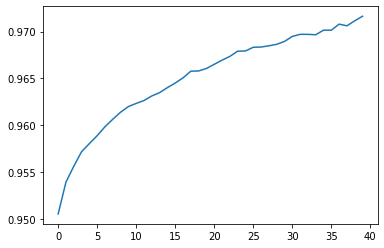

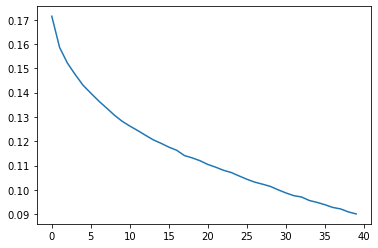

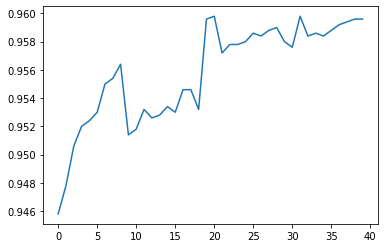

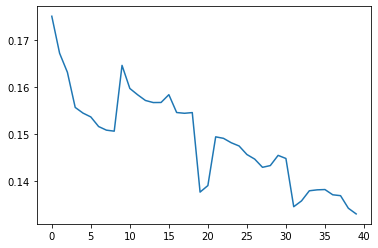

max val_accuracy is :  0.97
###############################


In [139]:
n_classes = 5
fc_act = 'relu'
n_stride = 1

for n_filters in [32]:
    for kern_size in [5]:
    
        print('n_filters : ',n_init)
        print('kern_size : ',kern_size)
        print('n_stride : ',n_stride)
        model = model_2(n_filters,kern_size,n_stride,fc_act,n_classes,False,(140,1))
        # Define loss/optimizer/metrics
        # Find the right loss for multi-class classification
        loss_classif     =  tensorflow.keras.losses.categorical_crossentropy
        #loss_classif = tfa.losses.SigmoidFocalCrossEntropy()
        #loss_classif = loss

        # Set the optimizer
        optimizer = SGD(learning_rate=0.05)
        #optimizer = Adam(learning_rate=0.05)
        optimizer = tfa.optimizers.SWA(optimizer, start_averaging=0, average_period=3)

        # Set the metrics
        metrics_classif  =  ['accuracy']

        # Compile
        model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
        bs = 16
        n_epochs = 50

        history = model.fit(data_train_1D, labels_train_, batch_size=bs, epochs=n_epochs, validation_data=(data_test_1D, labels_test_))
    
        slid_wind_acc(history.history['accuracy'],10)
        slid_wind_acc(history.history['loss'],10)
        slid_wind_acc(history.history['val_accuracy'],10)
        slid_wind_acc(history.history['val_loss'],10)

        print('max val_accuracy is : ',np.max(history.history['val_accuracy']))
        print('###############################')

In [152]:
bs = 32
n_epochs = 50

history = model.fit(data_train_1D, labels_train_, batch_size=bs, epochs=n_epochs, validation_data=(data_test_1D, labels_test_))
#model.fit(data_train, labels_train_, batch_size=bs, epochs=n_epochs)

Train on 4935 samples, validate on 500 samples
Epoch 1/20
4935/4935 [==============================] - 19s 4ms/sample - loss: 0.4111 - accuracy: 0.8697 - val_loss: 0.3384 - val_accuracy: 0.9440
Epoch 2/20
4935/4935 [==============================] - 14s 3ms/sample - loss: 0.2943 - accuracy: 0.9050 - val_loss: 0.1895 - val_accuracy: 0.9500
Epoch 3/20
4935/4935 [==============================] - 15s 3ms/sample - loss: 0.2520 - accuracy: 0.9206 - val_loss: 0.1406 - val_accuracy: 0.9580
Epoch 4/20
4935/4935 [==============================] - 14s 3ms/sample - loss: 0.2320 - accuracy: 0.9246 - val_loss: 0.1723 - val_accuracy: 0.9580
Epoch 5/20
4935/4935 [==============================] - 14s 3ms/sample - loss: 0.2156 - accuracy: 0.9319 - val_loss: 0.1398 - val_accuracy: 0.9540
Epoch 6/20
4935/4935 [==============================] - 14s 3ms/sample - loss: 0.1979 - accuracy: 0.9388 - val_loss: 0.1513 - val_accuracy: 0.9560
Epoch 7/20
4935/4935 [==============================] - 15s 3ms/sample 

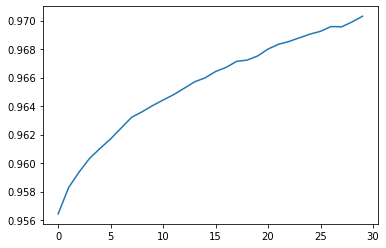

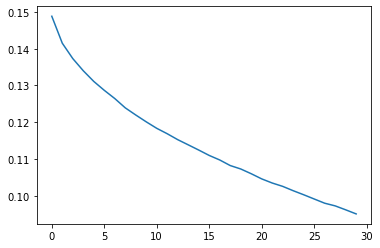

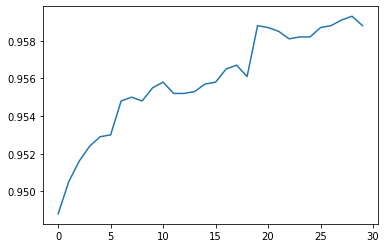

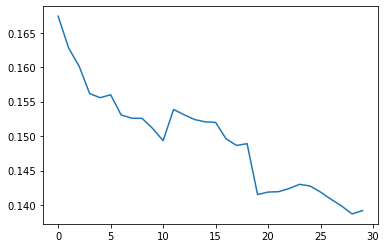

In [140]:
slid_wind_acc(history.history['accuracy'],10)
slid_wind_acc(history.history['loss'],10)
slid_wind_acc(history.history['val_accuracy'],10)
slid_wind_acc(history.history['val_loss'],10)

## Time series classification with sktime

#### K-nearest-neighbours classifier for time series

In [ ]:
#!pip install --user sktime

In [50]:
import sktime

In [51]:
from sktime.highlevel.tasks import TSCTask
from sktime.highlevel.strategies import TSCStrategy

from sktime.transformers.compose import RowwiseTransformer
from sktime.transformers.compose import ColumnTransformer
from sktime.transformers.compose import Tabulariser
from sktime.transformers.segment import RandomIntervalSegmenter

from sktime.pipeline import Pipeline
from sktime.pipeline import FeatureUnion
from sktime.classifiers.distance_based import ProximityForest 

from sktime.classifiers.compose import TimeSeriesForestClassifier
from sktime.classifiers.distance_based import KNeighborsTimeSeriesClassifier

from sktime.datasets import load_gunpoint
from sktime.utils.time_series import time_series_slope

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.ar_model import AR

from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

In [54]:
# KNN with DTW metric
knn = KNeighborsTimeSeriesClassifier(metric='dtw')
knn.fit(data_train_1D, labels_train)
confusion_matrix(labels_test, knn.predict(data_test_1D))

array([[291,   0,   0,   0,   1],
       [  0, 168,   3,   6,   0],
       [  0,   2,   8,   0,   0],
       [  1,   9,   1,   8,   0],
       [  0,   0,   0,   0,   2]], dtype=int64)

In [57]:
conf_mat = np.array([[291,   0,   0,   0,   1],
       [  0, 168,   3,   6,   0],
       [  0,   2,   8,   0,   0],
       [  1,   9,   1,   8,   0],
       [  0,   0,   0,   0,   2]], dtype='int64')
print(np.trace(conf_mat)/np.sum(conf_mat))

0.954


#### Fully modular time-series forest classifier (TSF)

In [58]:
import pandas as pd

In [59]:
steps = [
    ('segment', RandomIntervalSegmenter(n_intervals='sqrt')),
    ('transform', FeatureUnion([
        ('mean', RowwiseTransformer(FunctionTransformer(func=np.mean, validate=False))),
        ('std', RowwiseTransformer(FunctionTransformer(func=np.std, validate=False))),
        ('slope', RowwiseTransformer(FunctionTransformer(func=time_series_slope, validate=False)))
    ])),
    ('clf', DecisionTreeClassifier())
]
base_estimator = Pipeline(steps, random_state=1)

In [61]:
data_test_pd = pd.DataFrame(columns=['dim_0'])
for i in range(len(data_test)):
    data_test_pd = data_test_pd.append({'dim_0': data_test[i]}, ignore_index=True)
    
data_train_pd = pd.DataFrame(columns=['dim_0'])
for i in range(len(data_train)):
    data_train_pd = data_train_pd.append({'dim_0': data_train[i]}, ignore_index=True)

In [62]:
base_estimator.fit(data_train_pd, labels_train)
base_estimator.score(data_test_pd, labels_test)

0.928

In [ ]:
for k in range(1,15):
    print(str(k*10)," trees")
    tsf = TimeSeriesForestClassifier(base_estimator=base_estimator, 
                                 n_estimators=k*10,
                                 criterion='entropy',
                                 bootstrap=True, 
                                 oob_score=True, 
                                 random_state=1)
    tsf.fit(data_train_pd, labels_train)
    if tsf.oob_score:
        print(tsf.oob_score_)
    conf_mat = confusion_matrix(labels_test,tsf.predict(data_test_pd))
    print(conf_mat)
    print(np.trace(conf_mat)/np.sum(conf_mat))
    print('####')

#### Random Interval Spectral Ensemble

In [ ]:
def ar_coefs(x, maxlag=100):
    x = np.asarray(x).ravel()
    nlags = np.minimum(len(x) - 1, maxlag)
    model = AR(endog=x) 
    return model.fit(maxlag=nlags).params.ravel()

def acf_coefs(x, maxlag=100):
    x = np.asarray(x).ravel() 
    nlags = np.minimum(len(x) - 1, maxlag)
    return acf(x, nlags=nlags).ravel()

def powerspectrum(x, **kwargs):
    x = np.asarray(x).ravel()
    fft = np.fft.fft(x)
    ps = fft.real * fft.real + fft.imag * fft.imag
    return ps[:ps.shape[0] // 2].ravel()

In [ ]:
steps = [
    ('segment', RandomIntervalSegmenter(n_intervals=1, min_length=5)),
    ('transform', FeatureUnion([
        ('ar', RowwiseTransformer(FunctionTransformer(func=ar_coefs, validate=False))),
        ('acf', RowwiseTransformer(FunctionTransformer(func=acf_coefs, validate=False))),
        ('ps', RowwiseTransformer(FunctionTransformer(func=powerspectrum, validate=False)))
    ])),
    ('tabularise', Tabulariser()),
    ('clf', DecisionTreeClassifier())
]
base_estimator = Pipeline(steps)

In [ ]:
rise = TimeSeriesForestClassifier(base_estimator=base_estimator,
                                  n_estimators=50, 
                                  bootstrap=True,
                                  oob_score=True)

In [ ]:
rise.fit(data_train_pd, labels_train)
if rise.oob_score:
    print(rise.oob_score_)

In [ ]:
rise.score(data_test_pd, labels_test)

In [ ]:
confusion_matrix(labels_test,rise.predict(data_test_pd))

## SAVE

In [ ]:
# 1D-CNN takes in input (n_data,len_sequences,n_sensors)
# here we have only one sensor but we still need data to be in shape (n_data,len_sequences,1)
# and not (n_data,len_sequences)
n_init = 8
n_classes = 5
fc_act = 'relu'
n_stride = 20
#fc_act = mish

model = Sequential()

#add_conv_block_input(model, n_init, n_stride, fc_act, MaxPooling1D(3), (140,1))
model.add(Conv1D(n_init, n_stride, padding='same', input_shape=(140,1)))
model.add(BatchNormalization())
model.add(Activation(fc_act))
model.add(Conv1D(n_init, n_stride, padding='same'))
model.add(BatchNormalization())
model.add(Activation(fc_act))
model.add(MaxPooling1D(3))

model.add(Conv1D(2*n_init, n_stride, padding='same'))
model.add(BatchNormalization())
model.add(Activation(fc_act))
model.add(Conv1D(2*n_init, n_stride, padding='same'))
model.add(BatchNormalization())
model.add(Activation(fc_act))
model.add(MaxPooling1D(3))

model.add(Conv1D(4*n_init, n_stride, padding='same'))
model.add(BatchNormalization())
model.add(Activation(fc_act))
model.add(Conv1D(4*n_init, n_stride, padding='same'))
model.add(BatchNormalization())
model.add(Activation(fc_act))
model.add(MaxPooling1D(3))

model.add(Conv1D(8*n_init, n_stride, padding='same'))
model.add(BatchNormalization())
model.add(Activation(fc_act))
model.add(Conv1D(8*n_init, n_stride, padding='same'))
model.add(BatchNormalization())
model.add(Activation(fc_act))
model.add(GlobalAveragePooling1D())


#model.add(Dense(15))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))

In [ ]:
# Classical NN
n_classes = 5

model = Sequential()
model.add(Dense(70))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(35))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))

In [72]:
file_path = "C:\\Users\\cleme\\Desktop\\ENSAE_3a\\Deep Learning for Medical Imaging\\mit-bih-arrhythmia-database-1.0.0\mit-bih-arrhythmia-database-1.0.0"


In [76]:
myarray = np.fromfile(file_path+'\\101.dat', dtype=float)

In [77]:
myarray.shape

(243750,)

In [79]:
import pandas as pd
train_df = pd.read_csv('C:\\Users\\cleme\\Desktop\\ENSAE_3a\\Deep Learning for Medical Imaging\\heartbeat\\mitbih_train.csv',header=None)
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


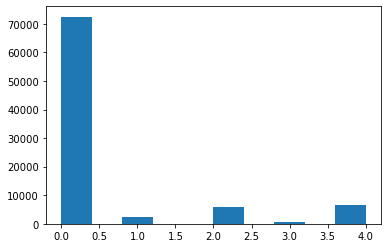

In [84]:
hist_train = plt.hist(train_df.values[:,-1])

In [86]:
hist_train[0]/np.sum(hist_train[0])

array([0.82772917, 0.        , 0.02539005, 0.        , 0.        ,
       0.06610777, 0.        , 0.0073212 , 0.        , 0.07345181])